## GLMAT: 2D kernel, song stimuli, biophysical model, ML+MC estimation

This notebook tests the full estimation method on data generated by a biophysical dSTRF model. The goal ois to estimate the parameters of the RF and the adaptation kernels. The parameter count of the RF is minimized by using a low-rank approximation (i.e., an outer product of two vectors) and by projecting time into a basis set of raised cosine filters that are spaced exponentially.

In [1]:
from __future__ import print_function, division
import os
import sys
import imp
import numpy as np

from dstrf import strf, mle, io, spikes, performance, filters, models

# plotting packages
%reload_ext yamlmagic
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package

sns.set_style("whitegrid")
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'

In [2]:
%%yaml cfg
model:
  dt: 0.5
  ataus: [10.0, 200.0]
  t_refract: 2.0
  filter:
    rank: 1
    len: 30
    ncos: 8
  prior:
    l1: 62.567
    l2: 6.9519
data:
  dt: 1.0
  stimulus:
    source: "dstrf_sim"
    root: "/home/data/dstrf_sim"
    cell: "b-tonic-24"
    spectrogram:
      window: 2.5
      compress: 10
      nfreq: 20
      f_min: 0.0
      f_max: 8.0
      gammatone: False
  test_proportion: 0.2

<IPython.core.display.Javascript object>

In [3]:
from munch import munchify
cf = munchify(cfg)

model_dt = cf.model.dt
stim_dt = cf.data.dt
upsample = int(stim_dt / model_dt)
ntau = cf.model.filter.len
nfreq = cf.data.stimulus.spectrogram.nfreq

Here we load data from the dSTRF experiments. Each RF was convolved with 30 different songs, then the linear output was fed into the biophysical equations.

In [4]:
# data parameters - the number of trials for assimilation and for testing
pad_before = 0    # how much to pad stimulus before onset
pad_after = ntau * stim_dt # how much to pad after offset
n_trials = 10      # set the number of trials to use (needs to be the same for all stimuli)
p_test = 0.5      # proportion of trials to use for test

# song stimulus:
root = "/scratch/dmeliza/modeldata/SNR4posp-norm/"
cell = "b-tonic-24"
sparams = cf.data.stimulus.spectrogram
data = io.load_rothman(cell, root, sparams.window, stim_dt, 
                       f_min=sparams.f_min, f_max=sparams.f_max, 
                       f_count=sparams.nfreq, 
                       compress=sparams.compress, gammatone=sparams.gammatone,
                       load_internals=True)

io.pad_stimuli(data, pad_before, pad_after, fill_value=0.0);
io.preprocess_spikes(data, model_dt, cf.model.ataus)

n_test = int(cf.data.test_proportion * len(data))
# split into assimilation and test sets and merge stimuli
assim_data = io.merge_data(data[:-n_test])
test_data = io.merge_data(data[-n_test:])

0
t_peak     8.195173
f_peak     2.844950
t_sigma    4.365620
t_omega    0.043980
f_sigma    1.504595
f_omega    0.132926
Pt         1.570796
Name: 1, dtype: float64


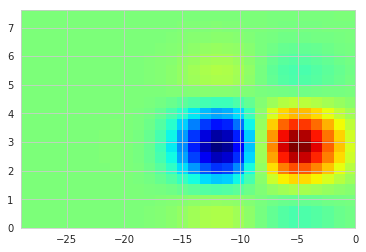

In [6]:
rf_params = io.load_rothman_rf_params(cell, root)
k1, k1t, k1f = filters.hg(nfreq=nfreq, ntau=ntau, 
                          f_max=cf.data.stimulus.spectrogram.f_max, t_max=ntau * stim_dt, 
                          ampl=1.0, Pf= 0.0, 
                          **rf_params)
print(rf_params)
plt.imshow(k1, extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]), cmap='jet', aspect='auto');

In [10]:
print("duration:", assim_data["duration"])
print("stim bins:", assim_data["stim"].shape[1])
print("spike bins:", assim_data["spike_v"].shape[0])
print("I_max:", np.max(assim_data["I"]))
print("I_rms:", np.sqrt((assim_data["I"] ** 2).mean()))
print("total spikes:", np.sum(assim_data["spike_v"]))

duration: 50472.0
stim bins: 50472
spike bins: 100944
I_max: 463.65696092733236
I_rms: 75.5063817804761
total spikes: 2781


0.1717333723161194 0.10865734162297573
1.0047777875624584 1.0036805351280158


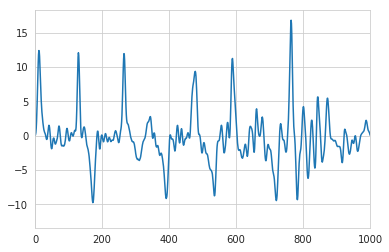

In [22]:
z = np.load("/scratch/dmeliza/modeldata/SNR4posp-norm/b-tonic-24/rf.npz")
rf = z['rf']
print(k1.max(), rf.max())
print((k1**2).sum(), (rf**2).sum())
II = strf.convolve(data[0]["stim"], k1)
It = np.linspace(0, data[0]["duration"], II.size)
plt.plot(It, II)
plt.xlim(0, 1000);

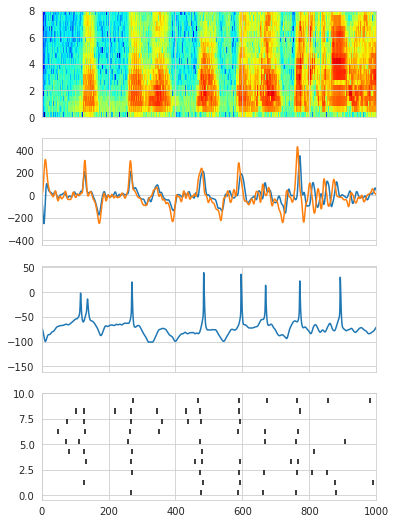

In [27]:
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 9))

stim = assim_data["stim"]
axes[0].imshow(assim_data["stim"], 
               extent=(0, assim_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])
t_current = np.linspace(0, assim_data["duration"], assim_data["I"].size)
t_voltage = np.linspace(0, assim_data["duration"], assim_data["V"].size)
axes[1].plot(t_current, assim_data["I"], It, II * rf_params["f_sigma"] * 17)
axes[2].plot(t_voltage, assim_data["V"])
for i, spk in enumerate(assim_data["spike_t"]):
    axes[3].vlines(spk * model_dt, i, i + 0.5)

axes[0].set_xlim(0,1000);

## Estimate parameters

The reg_alpha and reg_lambda parameters set the L1 and L2 penalties for the initial ML estimation. Note that we supply the nonlinearity function to the constructor too, as this determines how the log-likelihood is calculated.

In [ ]:
krank = cf.model.filter.rank
kcosbas = strf.cosbasis(cf.model.filter.len, cf.model.filter.ncos)
try:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])
except TypeError:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])    

In [ ]:
%time w0 = mlest.estimate(reg_lambda=cf.model.prior.l2, reg_alpha=cf.model.prior.l1)

In [ ]:
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

In [ ]:
import progressbar
from dstrf import crossvalidate

#reg_grid = np.logspace(-1, 5, 50)[::-1]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95]
reg_grid = np.logspace(-1, 5, 20)[::-1]
scores = []
results = []

bar = progressbar.ProgressBar(max_value=len(l1_ratios) * len(reg_grid),
                              widgets=[
                                ' [', progressbar.Timer(), '] ',
                                progressbar.Bar(),
                                ' (', progressbar.ETA(), ') ',
                            ])
for reg, s, w in bar(crossvalidate.elasticnet(mlest, 4, reg_grid, l1_ratios, avextol=1e-5, disp=False)):
    scores.append(s)
    results.append((reg, s, w))
    
best_idx = np.argmax(scores)
(rf_alpha, rf_lambda), ll, w0 = results[best_idx]

In [ ]:
print("best regularization params: alpha={}, lambda={}".format(rf_alpha, rf_lambda))
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

In [ ]:
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"])

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(9,9))
axes[0].imshow(assim_data["stim"], 
               extent=(0, test_data["duration"], sparams.f_min, sparams.f_max),
               cmap='jet', origin='lower', aspect='auto')

t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
t_spike = np.linspace(0, test_data["duration"], test_data["spike_v"].shape[0])
V = strf.convolve(test_data["stim"], k1)
Vpred = mltest.V(w0)
axes[1].plot(t_stim, V, t_stim, Vpred)

n_trials = test_data["ntrials"]
for i, spk in enumerate(test_data["spike_t"]):
    axes[2].vlines(spk * cf.model.dt, i - 0.4 + n_trials, i + 0.4 + n_trials)
pred = np.zeros_like(test_data["spike_v"])
for j in range(n_trials):
    pred[:, j] = models.predict_spikes_glm(Vpred, w0[:3], cf)
    spk_t = pred[:, j].nonzero()[0]
    axes[2].vlines(spk_t * cf.model.dt, j - 0.4, j + 0.4, color='r')

upsample = int(cf.data.dt / cf.model.dt)   
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
axes[3].plot(t_stim, test_psth, t_stim, pred_psth)
axes[3].set_xlim(12000, 13000);

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("EO cc: %3.3f" % eo)
print("pred cc: %3.3f" % np.corrcoef(test_psth, pred_psth)[0, 1])
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))

We'll use the ML estimate to seed the MCMC sampler. We're going to reduce the size of the parameter space by factorizing the RF (i.e., a bilinear approximation). Note that we try to use the mlest object as much as possible to do the calculations rather than reimplement things; however, there can be some significant performance enhancements from an optimized implementation.

In [ ]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos

# the MAT parameters are just bounded between reasonable limits. These may need to be expanded when using real data.
mat_prior = priors.joint_independent(
                [ priors.uniform( 0,  20),
                  priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                ])

def lnpost(theta):
    """Posterior probability for dynamical parameters"""
    mparams = theta[:3]
    rfparams = theta[3:]
    #rf_prior = -np.sum(np.abs(rfparams)) * rf_alpha - np.dot(rfparams, rfparams) * rf_lambda
    ll = mat_prior(mparams) #+ rf_prior
    if not np.isfinite(ll):
        return -np.inf
    w = np.r_[mparams, rfparams]
    ll -= mlest.loglike(w, rf_lambda, rf_alpha)
    return -np.inf if not np.isfinite(ll) else ll

In [ ]:
# get low-rank approx of the ML STRF
# k0f, k0t = strf.factorize(strf.as_matrix(w0[3:], ntbas))
# rf_mlb = strf.from_basis(np.dot(k0f, k0t), kcosbas)
# w0_bl = np.r_[w0[:3], k0f.squeeze(), k0t.squeeze()]
print("lnpost of ML estimate: {}".format(lnpost(w0)))
%timeit lnpost(w0)

This code starts the MCMC sampler. We initialize the walkers (chains) in a gaussian around the ML estimate, with standard deviation 2x the absolute value of the best guess. The model converges fairly quickly, but then we let it sample for a while.

In [ ]:
import emcee
# assimilation parameters
if sys.platform == 'darwin':
    nthreads = 1
else:
    nthreads = 8
nwalkers = 500
nsteps = 500

# initialize walkers
pos = p0 = startpos.normal_independent(nwalkers, w0, np.abs(w0) * 2)
# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, w0.size, lnpost, threads=nthreads)

In [ ]:
# start the sampler
tracker = utils.convergence_tracker(nsteps, 100)
for pos, prob, like in tracker(sampler.sample(pos, iterations=nsteps, storechain=True)): 
    continue

In [ ]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
try:
    print("autocorrelation time: {}".format(sampler.acor))
except:
    pass    
w1 = np.median(pos, 0)
rfparams = w1[3:]
rf_map = strf.from_basis(strf.defactorize(rfparams, nfreq, krank), kcosbas)
print(w0[:matparams_n])
print(w1[:matparams_n])
# print("mle error: {}; map error: {}".format(strf.subspace(k1, rf_mle), strf.subspace(k1, rf_map)))
#plt.subplot(221)
#sns.heatmap(strf.from_basis(k1c, kcosbas), cmap='jet')
plt.subplot(222)
sns.heatmap(rf_mle[:,-13:], cmap='jet')
plt.subplot(224)
sns.heatmap(rf_map[:,-13:], cmap='jet')

In [ ]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['w','a1','a2',]
c = corner(mpos,
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs)

In [ ]:
mat.random_seed(1)
n_draw = 10
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], f_min, f_max))
vax = plt.subplot(312)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * model_dt, j, j + 0.5, 'r')
    
samples = np.random.permutation(nwalkers)[:n_draw]
pred = np.zeros((test_data["spike_v"].shape[0], n_draw), dtype=test_data["spike_v"].dtype)
for i, idx in enumerate(samples):
    mparams = pos[idx]
    V_mc = mltest.V(mparams)
    vax.plot(t_stim, V_mc)
    pred[:, i] = mltest.predict(mparams, matparams[3:], V_mc)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * model_dt, i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 4200)

#eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("loglike: {}".format(-mltest.loglike(w1)))
#print("CC: {}/{}".format(np.corrcoef(test_psth, pred_psth)[0, 1], eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum() / n_trials, pred.sum() / n_draw))

In [ ]:
%matplotlib inline
plt.figure(figsize=(4,6))
stim = test_data["stim"]
t_spike = np.linspace(0, test_data["duration"], test_data["spike_v"].shape[0])
#t_stim = np.linspace(0, test_data["duration"], test_data["I"].shape[0])

plt.subplot(511).imshow(test_data["stim"], extent=(0, test_data["duration"], f_min, f_max))

plt.subplot(512).vlines(test_data["spike_t"][5] * model_dt, -0.4, 0.4)
# for i, spk in enumerate(test_data["spike_t"]):
#     ax.vlines(spk * model_dt, i, i + 0.5)
plt.subplot(513).plot(t_stim, V_mc)
H = -test_data["spike_h"][:, :, 5]
plt.subplot(514).plot(t_spike, H)
lci = mltest.lci(w1)
plt.subplot(515).plot(t_spike, np.exp(lci[:, 5]))
for ax in plt.gcf().axes:
    ax.set_xlim(19760,21800)
plt.savefig("glm_fit_example_{}.pdf".format(cell))

In [ ]:
# save data for testing in the Pillow code
import scipy.io as sio
V = mlest.V_interp(theta_true).squeeze()
H = assim_resp[0]["H"]
mu = V - H[:, 0] * matparams[1] - H[:, 1] * matparams[2] - matparams[0]
sio.savemat('glmat_2dbi_song_twin.mat', {"stim": (stim - stim.mean(1)[:, np.newaxis]) / stim.std(1)[:, np.newaxis], 
                                         "spikes": assim_resp[0]["spike_v"],
                                         "stim_dt": stim_dt,
                                         "spike_dt": model_dt,
                                         "rf": k1,
                                         "Istim": V,
                                         "Itot": mu})